In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_path = "c:/Users/Userpc/Desktop/Projects/ML Shortcuts/Data/smoking.csv"
df = pd.read_csv(df_path)

In [3]:
df.head()

,outcome,smoker,age
0,Alive,Yes,23
1,Alive,Yes,18
2,Dead,Yes,71
3,Alive,No,67
4,Alive,No,64


In [4]:
def clean_data(dataf):
    return (dataf
            .assign(alive=lambda d: (d['outcome']=='Alive').astype(int))
            .assign(smokes=lambda d: (d['smoker']=='Yes').astype(int)))

In [5]:
cleaned_df = df.pipe(clean_data)
cleaned_df

,outcome,smoker,age,alive,smokes
0,Alive,Yes,23,1,1
1,Alive,Yes,18,1,1
2,Dead,Yes,71,0,1
3,Alive,No,67,1,0
4,Alive,No,64,1,0
...,...,...,...,...,...
1309,Alive,Yes,35,1,1
1310,Alive,No,33,1,0
1311,Alive,Yes,21,1,1
1312,Alive,No,46,1,0


In [6]:
cleaned_df.loc[lambda d: d['smokes'] == 1]['alive'].mean()

0.761168384879725

In [7]:
cleaned_df.loc[lambda d: d['smokes'] == 0]['alive'].mean()

0.6857923497267759

In [8]:
(cleaned_df
        .groupby(['smokes'])
        .agg(prob=('alive', np.mean)))

,prob
smokes,
0,0.685792
1,0.761168


<Axes: xlabel='age'>

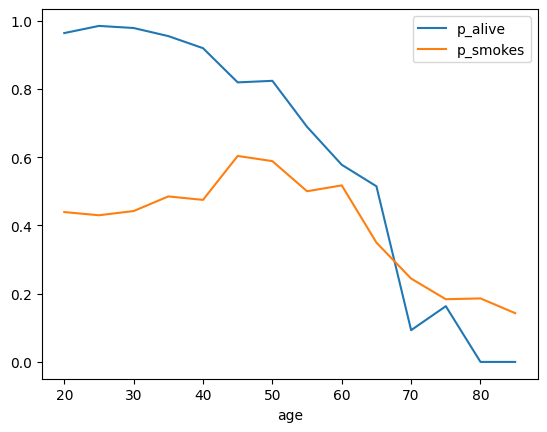

In [13]:
(cleaned_df
          .assign(age=lambda d: np.round(d['age'] / 5) * 5)
          .groupby(['age'])
          .agg(p_alive=('alive', np.mean),
               p_smokes=('smokes', np.mean))
          .plot()
        )

In [26]:
(cleaned_df
          .assign(age=lambda d: np.round(d['age'] / 10) * 10)
          .groupby(['age', 'smokes'])
          .agg(p=('alive', np.mean))
          .reset_index()
          .pivot(index='age',  columns='smokes', values='p')
          .assign(diff=lambda d: d[0] - d[1])
          ['diff'].mean()
        )

0.03449607015272389

In [29]:
df2 = pd.read_csv("c:/Users/Userpc/Desktop/Projects/ML Shortcuts/Data/sleep.csv")
df2.head()

,id,gpa,sleep,passed_unit_tests,passed_asserts,tackled_user_stories
0,1,23,normal,5,6,5
1,2,24,normal,1,3,2
2,3,23,normal,7,6,5
3,4,28,normal,5,8,4
4,5,25,normal,4,5,3


In [30]:
(df2
.groupby(['sleep'])
.agg(n=('id', 'count'),
     mean_unit_tests = ('passed_unit_tests', np.mean),
     mean_asserts = ('passed_asserts', np.mean),
     mean_user_stories = ('tackled_user_stories', np.mean)))

,n,mean_unit_tests,mean_asserts,mean_user_stories
sleep,,,,
deprived,15,1.133333,3.266667,1.600000
normal,21,2.904762,4.952381,2.714286


In [55]:
def reshuffle(dataf):
    return (dataf
                .sample(36)
                .reset_index(drop=True)
                .assign(sleep = lambda d: np.where(d.index < 15, 'deprived', 'normal')))

def calc_diff(dataf):
    agg = (dataf
            .groupby(['sleep'])
            .agg(mean_unit_tests = ('passed_unit_tests', np.mean),
                 mean_asserts = ('passed_asserts', np.mean),
                 mean_user_stories = ('tackled_user_stories', np.mean))).T
    return agg['deprived'] - agg['normal']

mean_unit_tests     -0.400000
mean_asserts         0.485714
mean_user_stories   -0.428571
dtype: float64

In [57]:
n = 1000
results = np.zeros((n, 3))
for i in range(n):
    results[i, :] = calc_diff(reshuffle(df2))

In [58]:
df_diff = pd.DataFrame(results, columns=[
    'diff_unit_tests',
    'diff_asserts',
    'diff_user_stories'
])

In [59]:
df_diff

,diff_unit_tests,diff_asserts,diff_user_stories
0,0.628571,0.257143,0.028571
1,0.400000,0.828571,0.257143
2,-0.971429,-0.428571,-0.542857
3,0.171429,0.257143,0.028571
4,1.314286,0.600000,0.828571
...,...,...,...
995,0.742857,-0.200000,0.371429
996,-0.171429,0.257143,-0.200000
997,0.514286,-0.542857,-0.200000
998,2.228571,0.714286,1.400000


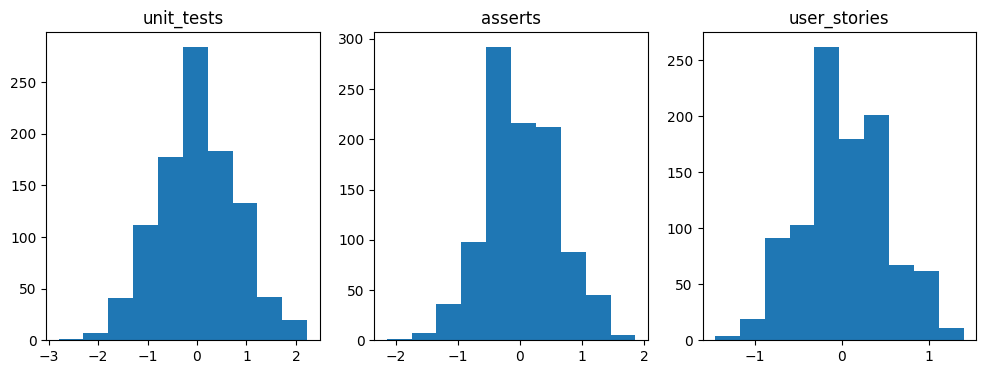

In [60]:
plt.figure(figsize=(12, 4))

for idx, name in enumerate(['unit_tests', 'asserts', 'user_stories']):
    plt.subplot(131 + idx)
    plt.hist(df_diff[f"diff_{name}"])
    plt.title(name)